In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, KFold, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score,mean_absolute_percentage_error
from mlxtend.feature_selection import SequentialFeatureSelector
from datetime import datetime, timedelta

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import joblib

In [4]:
dataset = pd.read_csv("bengaluru_parking_dataset.csv")

In [6]:
dataset.head(5)

,time,day_of_week,location,is_holiday,weather_condition,total_slots,free_slots_4w,free_slots_2w,event_nearby
0,20:00-22:00,Monday,Citywide Parking Overview,0,Sunny,5300,261,1257,0
1,14:00-16:00,Tuesday,Freedom Park,0,Sunny,1400,533,249,0
2,14:00-16:00,Wednesday,Church Street,0,Windy,500,28,56,1
3,08:00-10:00,Sunday,Freedom Park,0,Windy,1400,187,62,1
4,16:00-18:00,Thursday,Commercial Street,0,Sunny,325,19,79,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   time               2000 non-null   object
 1   day_of_week        2000 non-null   object
 2   location           2000 non-null   object
 3   is_holiday         2000 non-null   int64 
 4   weather_condition  2000 non-null   object
 5   total_slots        2000 non-null   int64 
 6   free_slots_4w      2000 non-null   int64 
 7   free_slots_2w      2000 non-null   int64 
 8   event_nearby       2000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 140.8+ KB


In [10]:
dataset.describe()

,is_holiday,total_slots,free_slots_4w,free_slots_2w,event_nearby
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.150000,1509.940000,291.344000,183.171500,0.192000
std,0.357161,1713.502806,474.932706,303.235247,0.393972
min,0.000000,300.000000,3.000000,11.000000,0.000000
25%,0.000000,370.000000,31.750000,59.000000,0.000000
50%,0.000000,550.000000,82.000000,97.000000,0.000000
75%,0.000000,2200.000000,376.000000,168.000000,0.000000
max,1.000000,6200.000000,3902.000000,3038.000000,1.000000


In [12]:
dataset.nunique()

time                  12
day_of_week            7
location              15
is_holiday             2
weather_condition      4
total_slots           13
free_slots_4w        708
free_slots_2w        457
event_nearby           2
dtype: int64

In [14]:
dataset.isnull().sum()

time                 0
day_of_week          0
location             0
is_holiday           0
weather_condition    0
total_slots          0
free_slots_4w        0
free_slots_2w        0
event_nearby         0
dtype: int64

In [16]:
dataset.shape

(2000, 9)

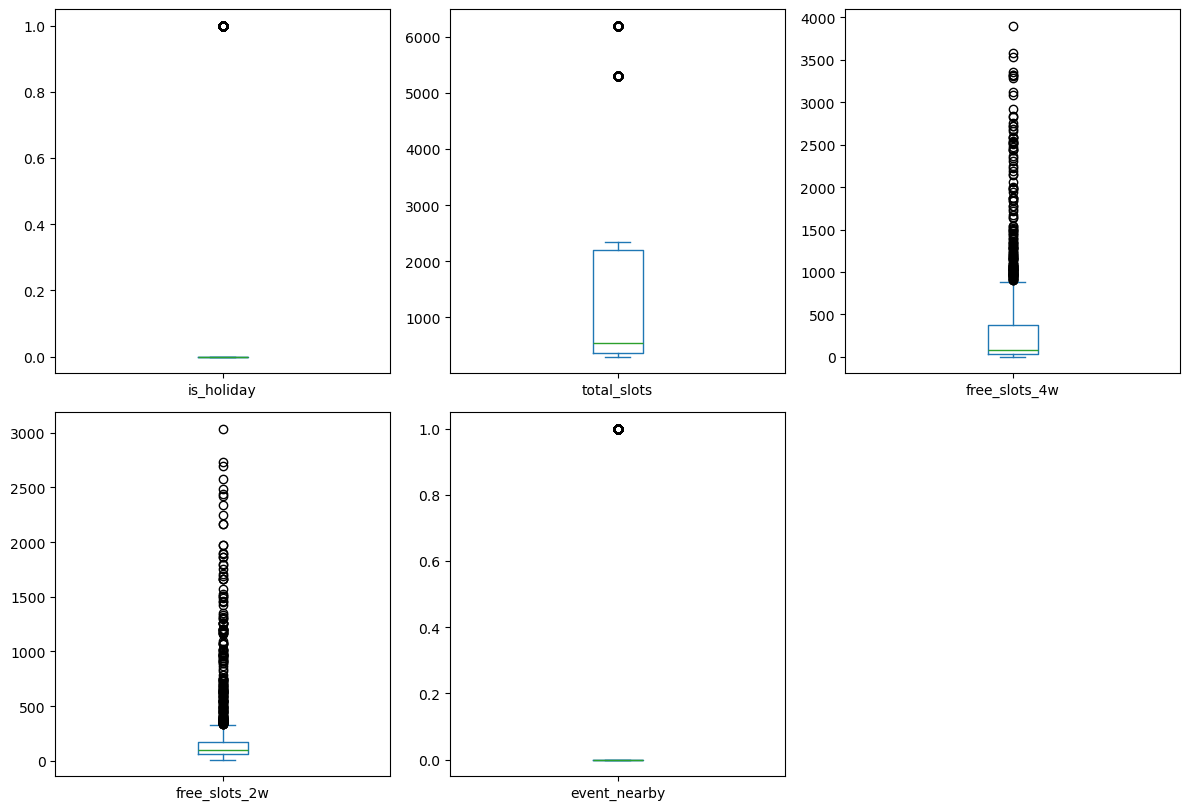

In [18]:
dataset.plot(kind="box", figsize=(12,12), layout=(3,3), sharex=False, subplots=True)
plt.tight_layout()

In [20]:
dataset["time"]

0       20:00-22:00
1       14:00-16:00
2       14:00-16:00
3       08:00-10:00
4       16:00-18:00
           ...     
1995    22:00-24:00
1996    08:00-10:00
1997    20:00-22:00
1998    20:00-22:00
1999    04:00-06:00
Name: time, Length: 2000, dtype: object

In [22]:
def time_to_hours(time_range):
    start_time, end_time = time_range.split('-')
    start_hour = int(start_time.split(':')[0]) + int(start_time.split(':')[1])/60
    end_hour = int(end_time.split(':')[0]) + int(end_time.split(':')[1])/60
    return start_hour, end_hour

In [24]:
dataset[['start_time', 'end_time']] = dataset['time'].apply(time_to_hours).apply(pd.Series)

In [31]:
dataset.drop('time', axis=1, inplace=True)

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day_of_week        2000 non-null   object 
 1   location           2000 non-null   object 
 2   is_holiday         2000 non-null   int64  
 3   weather_condition  2000 non-null   object 
 4   total_slots        2000 non-null   int64  
 5   free_slots_4w      2000 non-null   int64  
 6   free_slots_2w      2000 non-null   int64  
 7   event_nearby       2000 non-null   int64  
 8   start_time         2000 non-null   float64
 9   end_time           2000 non-null   float64
dtypes: float64(2), int64(5), object(3)
memory usage: 156.4+ KB


In [35]:
encoders = {}
for col in dataset.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])
    encoders[col] = le 

In [37]:
dataset.head(3)

,day_of_week,location,is_holiday,weather_condition,total_slots,free_slots_4w,free_slots_2w,event_nearby,start_time,end_time
0,1,2,0,2,5300,261,1257,0,20.0,22.0
1,5,4,0,2,1400,533,249,0,14.0,16.0
2,6,1,0,3,500,28,56,1,14.0,16.0


In [39]:
dataset.shape

(2000, 10)

In [41]:
dataset.columns

Index(['day_of_week', 'location', 'is_holiday', 'weather_condition',
       'total_slots', 'free_slots_4w', 'free_slots_2w', 'event_nearby',
       'start_time', 'end_time'],
      dtype='object')

In [43]:
x = dataset.drop(['free_slots_4w', 'free_slots_2w'], axis=1)
y = dataset[['free_slots_4w', 'free_slots_2w']]

In [45]:
y

,free_slots_4w,free_slots_2w
0,261,1257
1,533,249
2,28,56
3,187,62
4,19,79
...,...,...
1995,419,1263
1996,375,75
1997,14,34
1998,23,23


In [47]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [49]:
y_train

,free_slots_4w,free_slots_2w
968,40,60
240,63,126
819,15,76
692,55,75
420,5,31
...,...,...
1130,80,46
1294,45,69
860,21,96
1459,292,97


In [51]:
scaling = StandardScaler()
x_train_ss = scaling.fit_transform(x_train)
x_test_ss = scaling.transform(x_test)

In [54]:
sf01=SequentialFeatureSelector(RandomForestRegressor(n_estimators=30),k_features=8,forward=True)
sf01.fit(x,y)

SequentialFeatureSelector(estimator=RandomForestRegressor(n_estimators=30),
                          k_features=(8, 8), scoring='r2')

In [56]:
sf01.k_feature_names_

('day_of_week',
 'location',
 'is_holiday',
 'weather_condition',
 'total_slots',
 'event_nearby',
 'start_time',
 'end_time')

In [58]:
sf01.k_score_

0.7976569515157665

In [60]:
cross_val_mse1 = cross_val_score(RandomForestRegressor(), x, y, 
                                cv=KFold(n_splits=30),
                                scoring='neg_mean_squared_error')

# MAE
cross_val_mae1 = cross_val_score(RandomForestRegressor(), x, y, 
                                cv=KFold(n_splits=30),
                                scoring='neg_mean_absolute_error')

# R² (default)
cross_val_r2_1 = cross_val_score(RandomForestRegressor(), x, y, 
                               cv=KFold(n_splits=30))

In [61]:
mse_scores1 = -cross_val_mse1
mae_scores1 = -cross_val_mae1

In [64]:
cross_val_mse1,cross_val_mae1,cross_val_r2_1

(array([-20767.71168314, -17211.04927352, -17551.34265509, -17950.31762727,
        -30130.33177978, -47387.86531683, -69709.79689303, -40620.99873694,
        -26950.08721007, -21200.30231119, -25081.44554249, -41477.14385699,
        -34065.29502529, -21263.8045651 , -39393.4088596 , -49750.32630241,
        -15652.02561799, -19599.24063264, -12567.44046045, -25776.81301194,
        -15806.57165198, -19131.98621459, -42467.34998646, -20490.65539376,
        -47834.943217  , -33904.04087608, -37480.02816023, -32194.73186749,
        -31925.47464456, -52713.50412953]),
 array([-68.75871055, -57.50413921, -62.03158724, -55.97181254,
        -68.65690681, -86.34146233, -90.06566818, -84.01219794,
        -79.8552994 , -73.63738332, -66.83571131, -85.8629371 ,
        -79.95360572, -71.75713184, -83.27554957, -95.85983076,
        -51.47341068, -84.79899858, -49.90489697, -73.27788344,
        -57.83475613, -74.28343723, -90.72695779, -60.22314863,
        -85.37627904, -93.91039953, -87.

In [66]:
mse_scores1 = -cross_val_mse1
mae_scores1 = -cross_val_mae1
r2_scores1 = cross_val_r2_1

# Calculate mean and std
print("MSE: Mean = {:.2f}, Std = {:.2f}".format(np.mean(mse_scores1), np.std(mse_scores1)))
print("MAE: Mean = {:.2f}, Std = {:.2f}".format(np.mean(mae_scores1), np.std(mae_scores1)))
print("R²: Mean = {:.4f}, Std = {:.4f}".format(np.mean(r2_scores1), np.std(r2_scores1)))

MSE: Mean = 30935.20, Std = 13470.29
MAE: Mean = 75.81, Std = 13.24
R²: Mean = 0.7816, Std = 0.0783


In [68]:
params_rf = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'criterion': ['squared_error', 'absolute_error', 'poisson'],  # For regression tasks
    'max_depth': [5, 10, 15, 20, 30, None],  # Max depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when splitting a node
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'n_jobs': [-1]  # Using all processors for faster computation
}

In [70]:
rf = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(rf, param_distributions=params_rf, cv=5, 
                              scoring='neg_mean_squared_error', n_jobs=-1)
random_search_rf.fit(x_train_ss, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [5, 10, 15, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300],
                                        'n_jobs': [-1]},
                   scoring='neg_mean_squared_error')

In [72]:
print("Best Parameters:", random_search_rf.best_params_)
print("Best Score:", random_search_rf.best_score_)

Best Parameters: {'n_jobs': -1, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error', 'bootstrap': False}
Best Score: -26205.99802151562


In [74]:
rf1 = RandomForestRegressor(n_estimators= 200, criterion="poisson", max_depth=14,
                           max_features='log2', min_samples_leaf=2,
                           min_samples_split=10,
                           bootstrap= True)
rf1.fit(x_train_ss,y_train)

RandomForestRegressor(criterion='poisson', max_depth=14, max_features='log2',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=200)

In [76]:
rf1.score(x_train_ss,y_train)*100, rf1.score(x_test_ss,y_test)*100

(88.25679794202641, 83.08180068948407)

In [78]:
y_pred1 = rf1.predict(x_test_ss)

# Calculate evaluation metrics
mae1 = mean_absolute_error(y_test, y_pred1)
mse1 = mean_squared_error(y_test, y_pred1)
rmse1 = np.sqrt(mse1) 
r2_1 = r2_score(y_test, y_pred1)

# Print the results
print(f"Mean Absolute Error: {mae1}")
print(f"Mean Squared Error: {mse1}")
print(f"Root Mean Squared Error: {rmse1}")
print(f"R²: {r2_1}")

Mean Absolute Error: 86.55593949984866
Mean Squared Error: 38404.15776220527
Root Mean Squared Error: 195.96978788120703
R²: 0.8308180068948408


In [80]:
sf=SequentialFeatureSelector(XGBRegressor(),k_features=8,forward=True)
sf.fit(x,y)

SequentialFeatureSelector(estimator=XGBRegressor(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=None,
                                                 feature_weights=None,
                                                 gamma=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None, ...),
                          k_features=(8, 8), scoring='r2')

In [82]:
sf.k_feature_names_

('day_of_week',
 'location',
 'is_holiday',
 'weather_condition',
 'total_slots',
 'event_nearby',
 'start_time',
 'end_time')

In [84]:
sf.k_score_

0.7584924936294556

In [86]:
cross_val_mse2 = cross_val_score(XGBRegressor(), x, y, 
                                cv=KFold(n_splits=30),
                                scoring='neg_mean_squared_error')

# MAE
cross_val_mae2 = cross_val_score(XGBRegressor(), x, y, 
                                cv=KFold(n_splits=30),
                                scoring='neg_mean_absolute_error')

# R² (default)
cross_val_r2_2 = cross_val_score(XGBRegressor(), x, y, 
                                cv=KFold(n_splits=30))

In [88]:
mse_scores2 = -cross_val_mse2
mae_scores2 = -cross_val_mae2

In [90]:
cross_val_mse2,cross_val_mae2,cross_val_r2_2

(array([-26871.35546875, -19289.02148438, -34055.43359375, -13587.06933594,
        -37960.1171875 , -70249.9765625 , -72442.6171875 , -53302.08984375,
        -35410.9921875 , -25715.22460938, -29820.19921875, -53740.46484375,
        -45202.58984375, -30677.49023438, -50592.46484375, -56549.75390625,
        -16989.8515625 , -18687.50976562, -13451.22265625, -27990.32617188,
        -15180.33398438, -27145.18945312, -65822.5390625 , -11651.40917969,
        -63040.15625   , -36831.78515625, -56403.8203125 , -41349.0078125 ,
        -34306.23046875, -62049.21484375]),
 array([ -73.05491638,  -62.43200302,  -80.07862854,  -54.41897202,
         -74.70055389, -104.25977325,  -94.41322327,  -91.94033813,
         -85.27839661,  -78.17945862,  -73.21935272,  -97.29157257,
         -87.14250183,  -78.87923431,  -98.02835083, -105.06860352,
         -61.20478058,  -83.22872925,  -57.03845215,  -80.29412842,
         -59.88628387,  -86.34029388, -105.99984741,  -51.68117523,
         -90.983

In [92]:
mse_scores2 = -cross_val_mse2
mae_scores2 = -cross_val_mae2
r2_scores2 = cross_val_r2_2

# Calculate mean and std
print("MSE: Mean = {:.2f}, Std = {:.2f}".format(np.mean(mse_scores2), np.std(mse_scores2)))
print("MAE: Mean = {:.2f}, Std = {:.2f}".format(np.mean(mae_scores2), np.std(mae_scores2)))
print("R²: Mean = {:.4f}, Std = {:.4f}".format(np.mean(r2_scores2), np.std(r2_scores2)))

MSE: Mean = 38212.18, Std = 18091.94
MAE: Mean = 83.44, Std = 16.40
R²: Mean = 0.7400, Std = 0.1162


In [94]:
params_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

In [96]:
xgbst=XGBRegressor()
grid_search_bst = GridSearchCV(xgbst, param_grid=params_xgb, cv=3,
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_bst.fit(x_train_ss, y_train)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'reg_alpha': [0, 0.01, 0.1], 'reg_lambda': [1, 1.5, 2],
                         'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [98]:
print("Best Parameters:", grid_search_bst.best_params_)
print("Best Accuracy:", grid_search_bst.best_score_)

Best Parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 1}
Best Accuracy: -26479.327473958332


In [100]:
xgb_model = XGBRegressor(colsample_bytree=0.7, gamma=0.2,
                   learning_rate=0.2, max_depth=3,
                   n_estimators=200, reg_alpha=0.1,
                   reg_lambda=2, subsample=0.7)
xgb_model.fit(x_train_ss,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.2, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [102]:
xgb_model.score(x_train_ss,y_train)*100, xgb_model.score(x_test_ss,y_test)*100

(90.43266773223877, 84.04641151428223)

In [104]:
y_pred2 = xgb_model.predict(x_test_ss)

In [107]:
# Calculate evaluation metrics
mae2 = mean_absolute_error(y_test, y_pred2)
mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = np.sqrt(mse2) 
r2_2 = r2_score(y_test, y_pred2)

# Print the results
print(f"Mean Absolute Error: {mae2}")
print(f"Mean Squared Error: {mse2}")
print(f"Root Mean Squared Error: {rmse2}")
print(f"R²: {r2_2}")

Mean Absolute Error: 91.4555892944336
Mean Squared Error: 35999.6171875
Root Mean Squared Error: 189.73565080790695
R²: 0.8404641151428223


In [109]:
x.head(1)

,day_of_week,location,is_holiday,weather_condition,total_slots,event_nearby,start_time,end_time
0,1,2,0,2,5300,0,20.0,22.0


In [111]:
dataset.iloc[20:28]

,day_of_week,location,is_holiday,weather_condition,total_slots,free_slots_4w,free_slots_2w,event_nearby,start_time,end_time
20,3,14,1,2,300,38,35,0,0.0,2.0
21,1,9,0,1,370,12,59,0,20.0,22.0
22,3,5,0,2,400,45,40,0,2.0,4.0
23,3,6,0,0,1400,282,165,0,2.0,4.0
24,6,11,0,0,1700,678,220,0,22.0,24.0
25,3,1,0,3,500,41,56,0,6.0,8.0
26,2,0,1,2,385,29,88,1,22.0,24.0
27,4,3,0,2,325,36,62,0,8.0,10.0


In [113]:
prediction = pd.DataFrame([[1, 9, 0, 1, 370, 0, 20.0, 22.0]], columns=x.columns)
prediction_ss = scaling.transform(prediction)
xgb_model.predict(prediction_ss)

array([[48.043224, 73.521255]], dtype=float32)

In [115]:
prediction1 = pd.DataFrame([[3, 6, 0, 0, 1400, 0, 2.0, 4.0]], columns=x.columns)
prediction_ss1 = scaling.transform(prediction1)
xgb_model.predict(prediction_ss1)

array([[304.80124, 128.32324]], dtype=float32)

In [117]:
prediction2 = pd.DataFrame([[4, 3, 0, 2, 325, 0, 8.0, 10.0]], columns=x.columns)
prediction_ss2 = scaling.transform(prediction2)
xgb_model.predict(prediction_ss2)

array([[ 49.68179, 114.92557]], dtype=float32)

In [119]:
prediction2 = pd.DataFrame([[4, 3, 0, 2, 325, 0, 8.0, 10.0]], columns=x.columns)
prediction_ss2 = scaling.transform(prediction2)
rf1.predict(prediction_ss2)

array([[32.19529619, 97.66854272]])

In [121]:
prediction5 = pd.DataFrame([[6, 11, 0, 0, 1700, 0, 22.0, 24.0]], columns=x.columns)
prediction_ss5 = scaling.transform(prediction5)
xgb_model.predict(prediction_ss5)

array([[629.46326, 209.84082]], dtype=float32)

In [123]:
joblib.dump(rf1, 'rf_model.pkl')

['rf_model.pkl']

In [125]:
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [127]:
joblib.dump(scaling, 'scaler.pkl')

['scaler.pkl']

In [129]:
joblib.dump(encoders, 'encoder.pkl')

['encoder.pkl']